In [587]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.preprocessing import LabelEncoder

from sklearn import metrics
from sklearn.naive_bayes import GaussianNB

In [588]:
struct_df = pd.read_csv("Structural_Measures_-_Hospital.csv",dtype={'Provider ID': str})
struct_df.replace(["Not Available",""," "],np.nan,inplace=True)

In [589]:
pay_df = pd.read_csv("Payment_and_value_of_care_-_Hospital.csv",dtype={'Provider ID': str,'ZIP Code': str})
pay_df.replace(["Not Available",""," "],np.nan,inplace=True)

In [590]:
general_df = pd.read_csv("Hospital_General_Information.csv",dtype={'Provider ID': str})
general_df.replace(["Not Available",""," "],np.nan,inplace=True)

general_df.loc[:,"Hospital overall rating"] = general_df.loc[:,"Hospital overall rating"].astype(float)

In [591]:
pay_df = pay_df.drop(['Location','Phone number'],axis=1);
pay_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 19136 entries, 0 to 19135
Data columns (total 21 columns):
Provider ID                   19136 non-null object
Hospital name                 19136 non-null object
Address                       19136 non-null object
City                          19136 non-null object
State                         19136 non-null object
ZIP Code                      19136 non-null object
County name                   19092 non-null object
Payment measure name          19136 non-null object
Payment measure ID            19136 non-null object
Payment category              16176 non-null object
Denominator                   12518 non-null object
Payment                       12518 non-null object
Lower estimate                12518 non-null object
Higher estimate               12518 non-null object
Payment footnote              6629 non-null object
Value of care display name    19136 non-null object
Value of care display ID      19136 non-null object
Value of

In [592]:
pay_df.loc[:,"Payment"] = pd.to_numeric(pay_df["Payment"].apply(lambda x: str(x).replace("$","").replace(",","")),errors='coerce')
pay_df.loc[:,"Lower estimate"] = pd.to_numeric(pay_df["Lower estimate"].apply(lambda x: str(x).replace("$","").replace(",","")),errors='coerce')
pay_df.loc[:,"Higher estimate"] = pd.to_numeric(pay_df["Higher estimate"].apply(lambda x: str(x).replace("$","").replace(",","")),errors='coerce')

pay_df['Payment'].head(8)

0        NaN
1        NaN
2        NaN
3    21772.0
4        NaN
5        NaN
6        NaN
7    20485.0
Name: Payment, dtype: float64

In [593]:
pay_df[["Payment","Lower estimate","Higher estimate"]].head(5)

,Payment,Lower estimate,Higher estimate
0,NaN,NaN,NaN
1,NaN,NaN,NaN
2,NaN,NaN,NaN
3,21772.0,18143.0,25442.0
4,NaN,NaN,NaN


In [594]:
pay_df_index = pay_df.iloc[:,:7]
pay_df_index.columns

Index(['Provider ID', 'Hospital name', 'Address', 'City', 'State', 'ZIP Code',
       'County name'],
      dtype='object')

## Get the Payment estimates out

In [595]:
# Payment itself
tf_pay = pay_df.pivot(index="Provider ID", columns='Payment measure name', values='Payment').reset_index()
# Lower Estimatetf_pay_l
tf_pay_l = pay_df.pivot(index="Provider ID", columns='Payment measure name', values='Lower estimate').reset_index()
# Lower Estimate
tf_pay_h = pay_df.pivot(index="Provider ID", columns='Payment measure name', values='Higher estimate').reset_index()

In [596]:
placehold = tf_pay.columns.tolist()
for index, text  in enumerate(tf_pay.columns[1:]):
    placehold[index+1] = str(text) + " - actual"
tf_pay.columns = placehold
tf_pay.head(1)

,Provider ID,Payment for heart attack patients - actual,Payment for heart failure patients - actual,Payment for hip/knee replacement patients - actual,Payment for pneumonia patients - actual
0,010001,23394.0,17041.0,25812.0,18281.0


In [597]:
placehold = tf_pay_l.columns.tolist()
for index, text  in enumerate(tf_pay_l.columns[1:]):
    placehold[index+1] = str(text) + " - lower"
tf_pay_l.columns = placehold
tf_pay_l.head(1)

,Provider ID,Payment for heart attack patients - lower,Payment for heart failure patients - lower,Payment for hip/knee replacement patients - lower,Payment for pneumonia patients - lower
0,010001,22216.0,16268.0,24704.0,17354.0


In [598]:
placehold = tf_pay_h.columns.tolist()
for index, text  in enumerate(tf_pay_h.columns[1:]):
    placehold[index+1] = str(text) + " - higher"
tf_pay_h.columns = placehold
tf_pay_h.head(1)

,Provider ID,Payment for heart attack patients - higher,Payment for heart failure patients - higher,Payment for hip/knee replacement patients - higher,Payment for pneumonia patients - higher
0,010001,24641.0,17849.0,26982.0,19236.0


## Get Value of Care Respond

In [599]:
df_value = pay_df.iloc[:,-6:-1]
df_value = pd.concat([pay_df_index,df_value],axis=1)
df_value.columns

Index(['Provider ID', 'Hospital name', 'Address', 'City', 'State', 'ZIP Code',
       'County name', 'Value of care display name', 'Value of care display ID',
       'Value of care category', 'Value of care footnote',
       'Measure start date'],
      dtype='object')

In [600]:
tf_value = df_value.pivot(index="Provider ID", columns='Value of care display ID', values='Value of care category').reset_index()
tf_value.rename(columns={'MORT_PAYM_30_AMI': 'MORT_PAYM_30_HEART ATT', 'MORT_PAYM_30_PN': 'MORT_PAYM_30_PNEU','MORT_PAYM_30_HF': 'MORT_PAYM_30_HEART FAIL'}, inplace=True)

In [601]:
tf_value.head(2)

Value of care display ID,Provider ID,COMP_PAYM_90_HIP_KNEE,MORT_PAYM_30_HEART ATT,MORT_PAYM_30_HEART FAIL,MORT_PAYM_30_PNEU
0,010001,Average complications and higher payment,Average mortality and average payment,Average mortality and average payment,Average mortality and average payment
1,010005,Average complications and average payment,Average mortality and average payment,Worse mortality and average payment,Worse mortality and lower payment


In [602]:
for col in tf_value[2:]:
    x = tf_value[str(col)].str.split('and', 1, expand=True)

In [603]:
lst_value_df = []
for item in tf_value.columns.tolist()[1:len(tf_value.columns)]:
#     print(item)
    df = tf_value[item].str.split('and', 1, expand=True)
    df.columns = [item + "_1",item + "_2"]
    lst_value_df.append(df)

In [604]:
lst_value_df.append(tf_value.iloc[:,:1])
# for i in lst_value_df:
tf_value_split = pd.concat(lst_value_df, axis=1)

In [605]:
tf_value_split.head(2)

,COMP_PAYM_90_HIP_KNEE_1,COMP_PAYM_90_HIP_KNEE_2,MORT_PAYM_30_HEART ATT_1,MORT_PAYM_30_HEART ATT_2,MORT_PAYM_30_HEART FAIL_1,MORT_PAYM_30_HEART FAIL_2,MORT_PAYM_30_PNEU_1,MORT_PAYM_30_PNEU_2,Provider ID
0,Average complications,higher payment,Average mortality,average payment,Average mortality,average payment,Average mortality,average payment,010001
1,Average complications,average payment,Average mortality,average payment,Worse mortality,average payment,Worse mortality,lower payment,010005


In [606]:
tf_value_split.iloc[:,2].unique()

array(['Average mortality ', nan, 'Worse mortality ', 'Better mortality '],
      dtype=object)

## Get Structural Measures

In [607]:
struct_df.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 23920 entries, 0 to 23919
Data columns (total 15 columns):
Provider ID           23920 non-null object
Hospital Name         23920 non-null object
Address               23920 non-null object
City                  23920 non-null object
State                 23920 non-null object
ZIP Code              23920 non-null int64
County Name           23865 non-null object
Phone Number          23920 non-null object
Measure Name          23920 non-null object
Measure ID            23920 non-null object
Measure Response      17818 non-null object
Footnote              6102 non-null object
Measure Start Date    23920 non-null object
Measure End Date      23920 non-null object
Location              23920 non-null object
dtypes: int64(1), object(14)
memory usage: 2.7+ MB


In [608]:
struct_df.head(2)

,Provider ID,Hospital Name,Address,City,State,ZIP Code,County Name,Phone Number,Measure Name,Measure ID,Measure Response,Footnote,Measure Start Date,Measure End Date,Location
0,361313,MORROW COUNTY HOSPITAL,651 WEST MARION ROAD,MOUNT GILEAD,OH,43338,MORROW,(419) 946-5015,Patient Safety Culture,SM_HS_PATIENT_SAF,NaN,5 - Results are not available for this reporti...,01/01/2017,12/31/2017,"651 WEST MARION ROAD MOUNT GILEAD, OH 43338 (4..."
1,390183,ST LUKE'S MINERS MEMORIAL HOSPITAL,360 W RUDDLE STREET,COALDALE,PA,18218,SCHUYLKILL,(570) 645-2131,Safe surgery checklist use (inpatient),SM_SS_CHECK,Yes,NaN,01/01/2017,12/31/2017,"360 W RUDDLE STREET COALDALE, PA 18218 (40.821..."


In [609]:
# Payment itself
tf_struct = struct_df.pivot(index="Provider ID", columns='Measure Name', values='Measure Response').reset_index()

In [610]:
tf_struct.head(1)

Measure Name,Provider ID,Able to receive lab results electronically,"Able to track patients' lab results, tests, and referrals electronically between visits",Patient Safety Culture,Safe surgery checklist use (inpatient),Safe surgery checklist use (outpatient)
0,010001,Yes,Yes,Yes,Yes,Yes


In [611]:
tf_struct = tf_struct.replace({"Yes": 1,"No": 0})
tf_struct.head(2)

Measure Name,Provider ID,Able to receive lab results electronically,"Able to track patients' lab results, tests, and referrals electronically between visits",Patient Safety Culture,Safe surgery checklist use (inpatient),Safe surgery checklist use (outpatient)
0,010001,1.0,1.0,1.0,1.0,1.0
1,010005,1.0,1.0,0.0,1.0,1.0


## Combine all dataframes

In [612]:
tf_index = pay_df_index.drop_duplicates()

In [613]:
# Start with Index
complete = tf_index

list_of_df = [tf_value_split,tf_struct,tf_pay,tf_pay_l,tf_pay_h,general_df]
for each in list_of_df:
    each.loc[:,'Provider ID'] = each.loc[:,'Provider ID'].apply(str)
for each in list_of_df:
    complete = complete.merge(each,on="Provider ID",how="left")

In [614]:
complete.head(10)

,Provider ID,Hospital name,Address,City,State,ZIP Code,County name,COMP_PAYM_90_HIP_KNEE_1,COMP_PAYM_90_HIP_KNEE_2,MORT_PAYM_30_HEART ATT_1,...,Payment for heart attack patients - higher,Payment for heart failure patients - higher,Payment for hip/knee replacement patients - higher,Payment for pneumonia patients - higher,Hospital Type,Hospital Ownership,Emergency Services,Meets criteria for meaningful use of EHRs,Hospital overall rating,Mortality national comparison
0,171312,COMANCHE COUNTY HOSPITAL,2ND & FRISCO STREET,COLDWATER,KS,67029,COMANCHE,NaN,NaN,NaN,...,NaN,NaN,NaN,25442.0,Critical Access Hospitals,Government - Local,True,True,NaN,NaN
1,281326,ANTELOPE MEMORIAL HOSPITAL,"P O BOX 229, 102 WEST 9TH ST",NELIGH,NE,68756,ANTELOPE,NaN,NaN,NaN,...,NaN,NaN,NaN,22787.0,Critical Access Hospitals,Voluntary non-profit - Private,True,True,3.0,NaN
2,400021,HOSPITAL DE LA CONCEPCION,ROAD NUMBER 2 KM 173.4 CAIN ALTO,SAN GERMAN,PR,00683,SAN GERMAN,NaN,NaN,Average mortality,...,24844.0,18373.0,NaN,18950.0,Acute Care Hospitals,Voluntary non-profit - Church,True,True,NaN,Same as the national average
3,431309,COMMUNITY MEMORIAL HOSPITAL,809 JACKSON POST OFFICE BOX 319,BURKE,SD,57523,GREGORY,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Critical Access Hospitals,Voluntary non-profit - Private,True,True,NaN,NaN
4,330049,NORTHERN DUTCHESS HOSPITAL,6511 SPRINGBROOK AVENUE,RHINEBECK,NY,12572,DUTCHESS,Average complications,lower payment,Average mortality,...,26744.0,18169.0,19687.0,17995.0,Acute Care Hospitals,Voluntary non-profit - Private,True,True,4.0,Same as the national average
5,400115,CENTRO MEDICO WILMA N VAZQUEZ,CARR. 2 KM 39.5 ROAD NUMBER 2 BO ALGARROBO,VEGA BAJA,PR,00693,VEGA BAJA,NaN,NaN,NaN,...,NaN,NaN,NaN,NaN,Acute Care Hospitals,Proprietary,True,True,NaN,NaN
6,281344,CHERRY COUNTY HOSPITAL,"P O BOX 410, 510 NORTH GREEN ST",VALENTINE,NE,69201,CHERRY,Average complications,lower payment,NaN,...,NaN,NaN,20218.0,14791.0,Critical Access Hospitals,Government - Local,True,True,3.0,NaN
7,471300,GRACE COTTAGE HOSPITAL,PO BOX 216,TOWNSHEND,VT,05353,WINDHAM,NaN,NaN,NaN,...,NaN,NaN,NaN,25013.0,Critical Access Hospitals,Voluntary non-profit - Private,True,True,NaN,NaN
8,330055,NEW YORK-PRESBYTERIAN/QUEENS,56-45 MAIN STREET,FLUSHING,NY,11355,QUEENS,Average complications,higher payment,Average mortality,...,23341.0,18474.0,28502.0,20114.0,Acute Care Hospitals,Voluntary non-profit - Private,True,True,2.0,Above the national average
9,330085,AURELIA OSBORN FOX MEMORIAL HOSPITAL,ONE NORTON AVENUE,ONEONTA,NY,13820,OTSEGO,Average complications,average payment,Average mortality,...,23465.0,14231.0,24434.0,15148.0,Acute Care Hospitals,Voluntary non-profit - Private,True,True,3.0,Same as the national average


In [615]:
print("Fields to apply hot one encoding on:")
for col in complete: 
    if str(complete.loc[:,col].dtype).startswith(("float",'int'))== 0:
        complete.loc[:,col] = complete.loc[:,col].astype(str)
        print(complete.columns.get_loc(col),":", col)

Fields to apply hot one encoding on:
0 : Provider ID
1 : Hospital name
2 : Address
3 : City
4 : State
5 : ZIP Code
6 : County name
7 : COMP_PAYM_90_HIP_KNEE_1
8 : COMP_PAYM_90_HIP_KNEE_2
9 : MORT_PAYM_30_HEART ATT_1
10 : MORT_PAYM_30_HEART ATT_2
11 : MORT_PAYM_30_HEART FAIL_1
12 : MORT_PAYM_30_HEART FAIL_2
13 : MORT_PAYM_30_PNEU_1
14 : MORT_PAYM_30_PNEU_2
32 : Hospital Type
33 : Hospital Ownership
34 : Emergency Services
35 : Meets criteria for meaningful use of EHRs
37 : Mortality national comparison


In [616]:
com_coded = complete.copy()

lst_to_onehot = [28,29,30,31,32,33,34,35,37]

# Create dummy variables of 0 and 1 as a way to on hot code categorical variables without any ordinal purpose
dummies = pd.get_dummies(com_coded[com_coded.columns[lst_to_onehot]],dummy_na=False);

In [617]:
com_coded = pd.concat([com_coded.drop(com_coded.columns[lst_to_onehot],axis=1),dummies],axis=1)

In [618]:
com_coded.head(3)
com_coded.shape

(4784, 58)

In [619]:
print("Fields to apply label encoding on:")
for col in com_coded: 
    if str(com_coded.loc[:,col].dtype).startswith(("float",'int'))== 0:
        com_coded.loc[:,col] = com_coded.loc[:,col].astype(str)
        print(com_coded.columns.get_loc(col),":", col)

Fields to apply label encoding on:
0 : Provider ID
1 : Hospital name
2 : Address
3 : City
4 : State
5 : ZIP Code
6 : County name
7 : COMP_PAYM_90_HIP_KNEE_1
8 : COMP_PAYM_90_HIP_KNEE_2
9 : MORT_PAYM_30_HEART ATT_1
10 : MORT_PAYM_30_HEART ATT_2
11 : MORT_PAYM_30_HEART FAIL_1
12 : MORT_PAYM_30_HEART FAIL_2
13 : MORT_PAYM_30_PNEU_1
14 : MORT_PAYM_30_PNEU_2
33 : Hospital Type_Acute Care Hospitals
34 : Hospital Type_Childrens
35 : Hospital Type_Critical Access Hospitals
36 : Hospital Type_nan
37 : Hospital Ownership_Government
38 : Hospital Ownership_Government - Federal
39 : Hospital Ownership_Government - Hospital District or Authority
40 : Hospital Ownership_Government - Local
41 : Hospital Ownership_Government - State
42 : Hospital Ownership_Physician
43 : Hospital Ownership_Proprietary
44 : Hospital Ownership_Tribal
45 : Hospital Ownership_Voluntary non-profit - Church
46 : Hospital Ownership_Voluntary non-profit - Other
47 : Hospital Ownership_Voluntary non-profit - Private
48 : Hospi

In [620]:
labelencoder = LabelEncoder()
for i in range(1,15,1):
    com_coded.iloc[:, i] = labelencoder.fit_transform(com_coded.iloc[:, i])

In [621]:
com_coded.set_index("Provider ID", inplace=True)

In [622]:
# print("Fields to apply label encoding on:")
# for col in com_coded: 
#     if str(com_coded.loc[:,col].dtype).startswith(("float",'int'))== 0:
#         com_coded.loc[:,col] = com_coded.loc[:,col].astype(str)
#         print(com_coded.columns.get_loc(col),":", col)

In [623]:
com_coded.iloc[:,32:57] = com_coded.iloc[:,32:57].astype(float)
# com_coded = com_coded.astype(float)

In [624]:
com_coded_fina = com_coded.fillna(com_coded.mean())
com_coded_fina.info()

<class 'pandas.core.frame.DataFrame'>
Index: 4784 entries, 171312 to 150009
Data columns (total 57 columns):
Hospital name                                                                              4784 non-null int32
Address                                                                                    4784 non-null int32
City                                                                                       4784 non-null int32
State                                                                                      4784 non-null int32
ZIP Code                                                                                   4784 non-null int32
County name                                                                                4784 non-null int32
COMP_PAYM_90_HIP_KNEE_1                                                                    4784 non-null int32
COMP_PAYM_90_HIP_KNEE_2                                                                    4784 non-null int32
MOR

In [627]:
# hospital_overall_rating

## Develop Machine Learning Model

Try a dirty, fast model first:
- Naive Bayes

Then Random Tree

Then XGBoost if needed

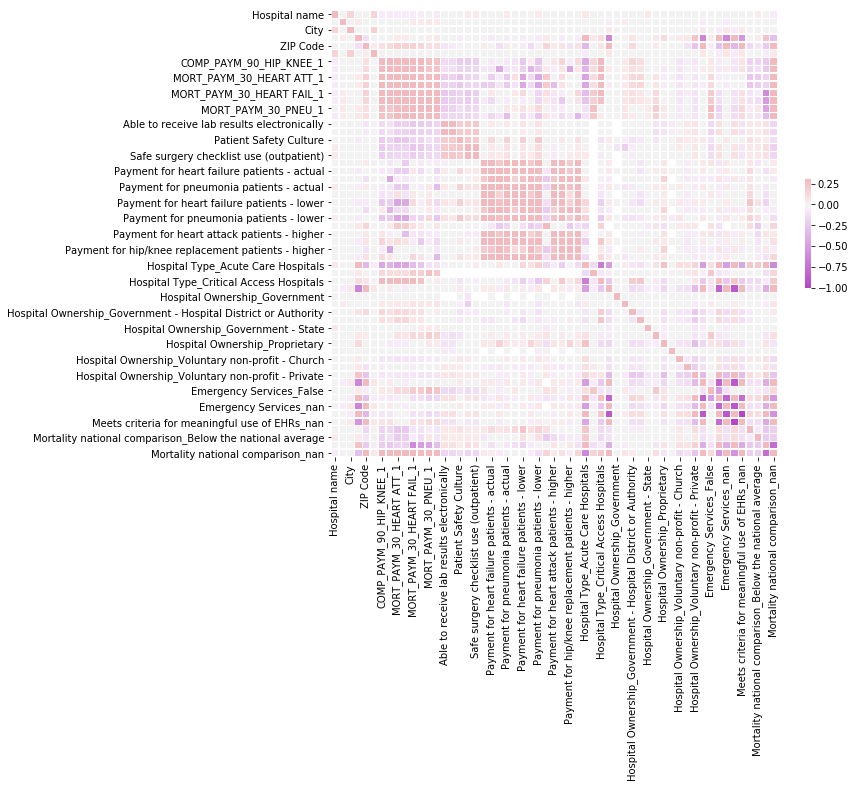

In [628]:
# TEST CORRLINEARILATIY 
corr = com_coded.corr()

plt.figure(figsize=(10,10))
cmap = sns.diverging_palette(300, 10, as_cmap=True)
sns.heatmap(corr,cmap=cmap, vmax=.3, center=0,
            square=True, linewidths=.5, cbar_kws={"shrink": .2})
# Find a correlation table that is less complicated visually
plt.show()
# This heatmap is for understanding colinearality 

Minimize highly correlated variables

In [629]:
# Select upper triangle of correlation matrix
upper = corr.where(np.triu(np.ones(corr.shape), k=1).astype(np.bool))

# Find index of feature columns with correlation greater than 0.90
to_drop_corr = [column for column in upper.columns if any(upper[column] > 0.90)]

# Then drop those columns
com_coded_fina = com_coded_fina.drop(to_drop_corr, axis=1)

In [630]:
print("After filling null values and dropping highly correlated features, we have:")
print(com_coded_fina.shape)
print("A drop from")
print(com_coded.shape, "in the original completed dataframe")

After filling null values and dropping highly correlated features, we have:
(4784, 46)
A drop from
(4784, 57) in the original completed dataframe


In [631]:
labels = com_coded_fina.loc[:,"MORT_PAYM_30_HEART ATT_1"]
features = com_coded_fina.drop("MORT_PAYM_30_HEART ATT_1", axis=1)

In [632]:
from sklearn.model_selection import train_test_split
train_features, test_features, train_labels, test_labels = train_test_split(features, labels, test_size = 0.15, random_state = 42)

In [633]:
guass_NB = GaussianNB()
guass_NB.fit(train_features,train_labels)

GaussianNB(priors=None, var_smoothing=1e-09)

In [634]:
predicted_labels = guass_NB.predict(test_features)

In [635]:
# Use classification_report to compare the test labels (what we know to be true) and the predicted labels generated by
# the Gaussian Naive Bayes
print(metrics.classification_report(test_labels, predicted_labels))

              precision    recall  f1-score   support

           0       0.82      0.51      0.63       322
           1       0.07      0.56      0.12         9
           2       0.00      0.00      0.00         1
           3       1.00      0.85      0.92       386

   micro avg       0.69      0.69      0.69       718
   macro avg       0.47      0.48      0.42       718
weighted avg       0.90      0.69      0.78       718



In [636]:
print(metrics.confusion_matrix(test_labels, predicted_labels))

[[165  65  92   0]
 [  4   5   0   0]
 [  1   0   0   0]
 [ 32   5  21 328]]
